Tyler Beaulieu  
Tim Paylor
DS5110, Fall 2025  
December 9, 2025  

<h4 style="text-align:center;">Final Project</h4>

In [1]:
#Initial Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from googleapiclient.discovery import build

### Phase 1: Look at file types.

In [2]:
#Load Google Drive API Key from .env file
load_dotenv()
API_KEY = os.getenv('GOOGLE_DRIVE_API_KEY')
if not API_KEY:
    raise ValueError("Please set GOOGLE_DRIVE_API_KEY")

#List files in Google Drive
service = build('drive', 'v3', developerKey=API_KEY)
folder_id = '12qMZKDEWn71JrN8Het5-a_NUWV0eE1ZF'

#Get the name of a folder by its ID
def get_folder_name(service, folder_id):
    try:
        folder = service.files().get(fileId=folder_id, fields='name').execute()
        return folder.get('name', '')
    except:
        return ''

#Return a list of dictionaries with file information for all files and folders
def list_files_recursively(service, folder_id, current_path="", parent_folder=""):
    all_files = []
    
    # List all items in the current folder
    results = service.files().list(
        q=f"'{folder_id}' in parents",
        pageSize=1000,
        fields="files(id, name, mimeType, size, modifiedTime)"
    ).execute()
    
    items = results.get('files', [])
    
    for item in items:
        file_info = {
            'id': item['id'],
            'name': item['name'],
            'mimeType': item['mimeType'],
            'size': item.get('size', 'N/A'),
            'modifiedTime': item.get('modifiedTime', 'N/A'),
            'path': current_path,
            'parent': parent_folder
        }
        
        # Check if it's a folder
        if item['mimeType'] == 'application/vnd.google-apps.folder':
            # Add folder to list
            all_files.append(file_info)
            
            # Recursively get files from subfolder
            subfolder_path = os.path.join(current_path, item['name'])
            subfolder_files = list_files_recursively(service, item['id'], subfolder_path, item['name'])
            all_files.extend(subfolder_files)
        else:
            # Add the file
            all_files.append(file_info)
    
    return all_files

# Get the root folder name for the path
parent_folder_name = get_folder_name(service, folder_id)

# Get all file details from Google Drive
file_list = list_files_recursively(service, folder_id, parent_folder_name, parent_folder_name)

# Convert to pandas DataFrame
df = pd.DataFrame(file_list)

# Create separate dataframes for folders and files
df_files = df[df['mimeType'] != 'application/vnd.google-apps.folder']
df_folders = df[df['mimeType'] == 'application/vnd.google-apps.folder']

# Display results
print(f"\nFound {len(df)} total items (files and folders)")
print(f"\n# Files: {len(df_files)}")
print(f"\n# Folders: {len(df_folders)}")


Found 9325 total items (files and folders)

# Files: 8672

# Folders: 653


In [3]:
#We look at our folders from the dataset.
df_folders.head(3)

,id,name,mimeType,size,modifiedTime,path,parent
0,11zxmvcEq_l1d3GgszcV63Xnk5rmuJw7j,Engineering Documents,application/vnd.google-apps.folder,N/A,2025-11-19T21:30:03.158Z,MPA,MPA
1,1Xw0LX4fdiEcS4rgt-cINK5TonnnNpOHG,2023 Reefer Yard Relocation,application/vnd.google-apps.folder,N/A,2025-11-19T21:30:05.299Z,MPA/Engineering Documents,Engineering Documents
4,1xwHiq1adtOcWU5eX7rrPJNg4KdTViCb4,AS BUILTS - USE THIS FOLDER,application/vnd.google-apps.folder,N/A,2025-11-19T21:30:05.272Z,MPA/Engineering Documents,Engineering Documents


In [4]:
#We look at our files from the dataset.
df_files.head(3)

,id,name,mimeType,size,modifiedTime,path,parent
2,15WbZHuFUhe79g-cm7sQp-0v5EZSH0NMQ,E2X93900_Draft 60% Review Set_2023.01.20.pdf,application/pdf,12869342,2025-11-19T18:58:43.000Z,MPA/Engineering Documents/2023 Reefer Yard Rel...,2023 Reefer Yard Relocation
3,1kPD2Jg3TSk1mfqYGqVozfVUqvEZvZvBJ,E2X93900_60% Drawings_20230224.pdf,application/pdf,12652508,2025-11-19T18:58:43.000Z,MPA/Engineering Documents/2023 Reefer Yard Rel...,2023 Reefer Yard Relocation
6,1gI7VVGbaQjP-6T0xB-OWOdwW6Ae2FCxT,Image C08 site plan.tif,image/tiff,1209995,2025-11-19T18:58:47.000Z,MPA/Engineering Documents/AS BUILTS - USE THIS...,IMT H2O SEWER Asbuilts C-08


In [5]:
#Look at the top file types
df_files.groupby('mimeType')['id'].count().sort_values(ascending=False)

mimeType
application/msword                                                           2820
application/pdf                                                              1739
image/jpeg                                                                   1497
application/vnd.ms-excel                                                      698
application/vnd.openxmlformats-officedocument.wordprocessingml.document       533
application/vnd.ms-powerpoint                                                 345
image/vnd.dwg                                                                 251
application/octet-stream                                                      184
application/vnd.openxmlformats-officedocument.presentationml.presentation      94
application/vnd.openxmlformats-officedocument.spreadsheetml.sheet              85
application/vnd.ms-outlook                                                     65
image/tiff                                                                     57
text/cs

For our files, lets divide type and subtype from mimeType

In [6]:
df_files[['type', 'subtype']] = df['mimeType'].str.split('/', expand=True)
df_files.head(5)


/var/folders/93/3q239911441bm0n94dg31l5c0000gn/T/ipykernel_2959/2609238651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_files[['type', 'subtype']] = df['mimeType'].str.split('/', expand=True)
/var/folders/93/3q239911441bm0n94dg31l5c0000gn/T/ipykernel_2959/2609238651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_files[['type', 'subtype']] = df['mimeType'].str.split('/', expand=True)


,id,name,mimeType,size,modifiedTime,path,parent,type,subtype
2,15WbZHuFUhe79g-cm7sQp-0v5EZSH0NMQ,E2X93900_Draft 60% Review Set_2023.01.20.pdf,application/pdf,12869342,2025-11-19T18:58:43.000Z,MPA/Engineering Documents/2023 Reefer Yard Rel...,2023 Reefer Yard Relocation,application,pdf
3,1kPD2Jg3TSk1mfqYGqVozfVUqvEZvZvBJ,E2X93900_60% Drawings_20230224.pdf,application/pdf,12652508,2025-11-19T18:58:43.000Z,MPA/Engineering Documents/2023 Reefer Yard Rel...,2023 Reefer Yard Relocation,application,pdf
6,1gI7VVGbaQjP-6T0xB-OWOdwW6Ae2FCxT,Image C08 site plan.tif,image/tiff,1209995,2025-11-19T18:58:47.000Z,MPA/Engineering Documents/AS BUILTS - USE THIS...,IMT H2O SEWER Asbuilts C-08,image,tiff
7,16gh23fs6ID6WSIxk4nrkbJO-1CM_a0HZ,IMT AsBuilts H2O and Sanitary.pdf,application/pdf,4843831,2025-11-19T18:58:47.000Z,MPA/Engineering Documents/AS BUILTS - USE THIS...,IMT H2O SEWER Asbuilts C-08,application,pdf
8,1E7TYkQjsML1ckSFMJE-oThzGYtBhI7uH,IMT AsBuilts H2O and Sanitary.bak,application/octet-stream,7165614,2025-11-19T18:58:47.000Z,MPA/Engineering Documents/AS BUILTS - USE THIS...,IMT H2O SEWER Asbuilts C-08,application,octet-stream


In [7]:
#Lets split the title of the file from the extension, by splitting off text after the last '.'
df_files[['title', 'extension']] = df_files['name'].str.rsplit('.', n=1, expand=True)
#Fill in any files that had no extension
df_files['extension'] = df_files['extension'].fillna('n/a')
df_files.head(10)

/var/folders/93/3q239911441bm0n94dg31l5c0000gn/T/ipykernel_2959/1385938359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_files[['title', 'extension']] = df_files['name'].str.rsplit('.', n=1, expand=True)
/var/folders/93/3q239911441bm0n94dg31l5c0000gn/T/ipykernel_2959/1385938359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_files[['title', 'extension']] = df_files['name'].str.rsplit('.', n=1, expand=True)
/var/folders/93/3q239911441bm0n94dg31l5c0000gn/T/ipykernel_2959/1385938359.py:4: Setti

,id,name,mimeType,size,modifiedTime,path,parent,type,subtype,title,extension
2,15WbZHuFUhe79g-cm7sQp-0v5EZSH0NMQ,E2X93900_Draft 60% Review Set_2023.01.20.pdf,application/pdf,12869342,2025-11-19T18:58:43.000Z,MPA/Engineering Documents/2023 Reefer Yard Rel...,2023 Reefer Yard Relocation,application,pdf,E2X93900_Draft 60% Review Set_2023.01.20,pdf
3,1kPD2Jg3TSk1mfqYGqVozfVUqvEZvZvBJ,E2X93900_60% Drawings_20230224.pdf,application/pdf,12652508,2025-11-19T18:58:43.000Z,MPA/Engineering Documents/2023 Reefer Yard Rel...,2023 Reefer Yard Relocation,application,pdf,E2X93900_60% Drawings_20230224,pdf
6,1gI7VVGbaQjP-6T0xB-OWOdwW6Ae2FCxT,Image C08 site plan.tif,image/tiff,1209995,2025-11-19T18:58:47.000Z,MPA/Engineering Documents/AS BUILTS - USE THIS...,IMT H2O SEWER Asbuilts C-08,image,tiff,Image C08 site plan,tif
7,16gh23fs6ID6WSIxk4nrkbJO-1CM_a0HZ,IMT AsBuilts H2O and Sanitary.pdf,application/pdf,4843831,2025-11-19T18:58:47.000Z,MPA/Engineering Documents/AS BUILTS - USE THIS...,IMT H2O SEWER Asbuilts C-08,application,pdf,IMT AsBuilts H2O and Sanitary,pdf
8,1E7TYkQjsML1ckSFMJE-oThzGYtBhI7uH,IMT AsBuilts H2O and Sanitary.bak,application/octet-stream,7165614,2025-11-19T18:58:47.000Z,MPA/Engineering Documents/AS BUILTS - USE THIS...,IMT H2O SEWER Asbuilts C-08,application,octet-stream,IMT AsBuilts H2O and Sanitary,bak
9,1dJST5hK9G_4QjAoxy2X6fWIg445SI-fF,IMT AsBuilts H2O and Sanitary.ini,application/octet-stream,34,2025-11-19T18:58:47.000Z,MPA/Engineering Documents/AS BUILTS - USE THIS...,IMT H2O SEWER Asbuilts C-08,application,octet-stream,IMT AsBuilts H2O and Sanitary,ini
10,1INTRSX59xNSczsQWpZ7zAsCBXauCQIIG,H2O and Sanitary Asbuilt Points.csv,text/csv,3623,2025-11-19T18:58:47.000Z,MPA/Engineering Documents/AS BUILTS - USE THIS...,IMT H2O SEWER Asbuilts C-08,text,csv,H2O and Sanitary Asbuilt Points,csv
11,1RnnmegRZIrUbrKpsgjtkkJ8OiU5bu4xm,IMT AsBuilts H2O and Sanitary.dwg,image/vnd.dwg,7493239,2025-11-19T18:58:47.000Z,MPA/Engineering Documents/AS BUILTS - USE THIS...,IMT H2O SEWER Asbuilts C-08,image,vnd.dwg,IMT AsBuilts H2O and Sanitary,dwg
12,1kNv8fTffolaPOklDiOXW31DhDn4mdh6n,Shaw Brothers logo 1x1.jpg,image/jpeg,18601,2025-11-19T18:58:47.000Z,MPA/Engineering Documents/AS BUILTS - USE THIS...,IMT H2O SEWER Asbuilts C-08,image,jpeg,Shaw Brothers logo 1x1,jpg
14,1TRI-GgGQOKSIw_uiyJyPc85SHN6l-jGW,sbc IMT GAS Asbuilts.pdf,application/pdf,4873136,2025-11-19T18:58:47.000Z,MPA/Engineering Documents/AS BUILTS - USE THIS...,IMT GAS Asbuilts C-08,application,pdf,sbc IMT GAS Asbuilts,pdf


In [8]:
#Export our files to CSV
df.to_csv('data/allfilesfolders.csv')
df_files.to_csv('data/files.csv')
df_folders.to_csv('data/folders.csv')

OSError: Cannot save file into a non-existent directory: 'data'

In [ ]:
#Look at the top file extensions
df_files.groupby('extension')['id'].count().sort_values(ascending=False)

extension
doc        2776
pdf        1715
jpg        1403
xls         570
docx        533
ppt         333
dwg         251
XLS         128
pptx         94
JPG          86
xlsx         85
ini          80
bak          76
msg          65
csv          55
zip          46
tif          45
png          32
DOC          29
log          27
gif          24
bmp          24
crd          20
txt          16
n/a          16
PDF          15
rtf          12
htm          12
TIF          12
js           12
dxf          10
docm          8
pptm          8
pot           8
css           8
dotx          4
pub           4
jpeg          4
eps           4
pps           4
xmp           4
psd           4
dot           3
xlsm          3
partial       1
lnk           1
m3u           1
m4a           1
Name: id, dtype: int64

In [ ]:
#Look at the folders with the most files
df_files.groupby('parent')['id'].count().sort_values(ascending=False)

parent
Maine-Port-Atuh-8-28-09-B    768
Portland-IMT                 664
MPA JH                       632
CruiseMaine                  429
Searsport                    405
                            ... 
RFPRFQ                         1
SNFP Improvement               1
Stevedore                      1
Vertical Conveyor              1
cache                          1
Name: id, Length: 230, dtype: int64

# Looking for Duplicate Files

In [30]:
#Create a dataframe with just the core file information
#Name, size of file, type of file
df_filenames = df_files[['name','size','subtype']]
print(f'Total files: {len(df_filenames)}')
#Create a dataframe without duplicate files
unique_files = df_files.drop_duplicates(subset=['name', 'size', 'subtype'])
#unique_files = df_filenames.drop_duplicates()
print(f'Total unique files: {len(unique_files)}')

Total files: 8672
Total unique files: 3202


In [ ]:
#Create a dataframe with just folder names
df_foldernames = df_folders['name']
print(f'Total folders: {len(df_foldernames)}')
#Create a dataframe of unique folder names
unique_folders = df_foldernames.drop_duplicates()
print(f'Total unique folder names: {len(unique_folders)}')

Total folders: 653
Total unique folder names: 257


Now that we have identified that there are a large number of duplicates, I want to see if we can find any duplicate folders.

In [ ]:
#'application', 'image', 'text', 'audio'
#Add columns to df_files for filetype
df_files['is_doc'] = (df_files['type'] == 'application').astype(int)+(df_files['type'] == 'text').astype(int)
df_files['is_img'] = (df_files['type'] == 'image').astype(int)
df_files['is_audio'] = (df_files['type'] == 'audio').astype(int)
df_files.head(5)

C:\Users\tyler\AppData\Local\Temp\ipykernel_41592\3858956102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_files['is_doc'] = (df_files['type'] == 'application').astype(int)+(df_files['type'] == 'text').astype(int)
C:\Users\tyler\AppData\Local\Temp\ipykernel_41592\3858956102.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_files['is_img'] = (df_files['type'] == 'image').astype(int)
C:\Users\tyler\AppData\Local\Temp\ipykernel_41592\3858956102.py:5: SettingWithCopyWarning: 
A value is trying to 

,id,name,mimeType,size,modifiedTime,path,parent,type,subtype,title,extension,is_doc,is_img,is_audio
2,15WbZHuFUhe79g-cm7sQp-0v5EZSH0NMQ,E2X93900_Draft 60% Review Set_2023.01.20.pdf,application/pdf,12869342,2025-11-19T18:58:43.000Z,MPA\Engineering Documents\2023 Reefer Yard Rel...,2023 Reefer Yard Relocation,application,pdf,E2X93900_Draft 60% Review Set_2023.01.20,pdf,1,0,0
3,1kPD2Jg3TSk1mfqYGqVozfVUqvEZvZvBJ,E2X93900_60% Drawings_20230224.pdf,application/pdf,12652508,2025-11-19T18:58:43.000Z,MPA\Engineering Documents\2023 Reefer Yard Rel...,2023 Reefer Yard Relocation,application,pdf,E2X93900_60% Drawings_20230224,pdf,1,0,0
6,1gI7VVGbaQjP-6T0xB-OWOdwW6Ae2FCxT,Image C08 site plan.tif,image/tiff,1209995,2025-11-19T18:58:47.000Z,MPA\Engineering Documents\AS BUILTS - USE THIS...,IMT H2O SEWER Asbuilts C-08,image,tiff,Image C08 site plan,tif,0,1,0
7,16gh23fs6ID6WSIxk4nrkbJO-1CM_a0HZ,IMT AsBuilts H2O and Sanitary.pdf,application/pdf,4843831,2025-11-19T18:58:47.000Z,MPA\Engineering Documents\AS BUILTS - USE THIS...,IMT H2O SEWER Asbuilts C-08,application,pdf,IMT AsBuilts H2O and Sanitary,pdf,1,0,0
8,1E7TYkQjsML1ckSFMJE-oThzGYtBhI7uH,IMT AsBuilts H2O and Sanitary.bak,application/octet-stream,7165614,2025-11-19T18:58:47.000Z,MPA\Engineering Documents\AS BUILTS - USE THIS...,IMT H2O SEWER Asbuilts C-08,application,octet-stream,IMT AsBuilts H2O and Sanitary,bak,1,0,0


In [ ]:
folder_summary = df_files.groupby('path').agg({
    'size': 'sum',
    'is_doc': 'sum',
    'is_img': 'sum',
    'is_audio': 'sum',
    'id': 'count',
    'parent': 'first'
}).reset_index()
folder_summary = folder_summary.sort_values('parent')
folder_summary['duplicate_count'] = folder_summary.groupby(['size', 'is_doc', 'is_img', 'is_audio', 'id', 'parent'])['path'].transform('count')
potential_duplicates = folder_summary[folder_summary['duplicate_count'] > 1]
potential_duplicates.to_csv('data/dupes.csv')


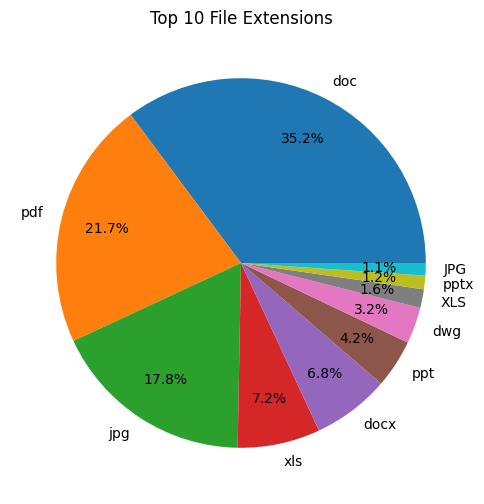

<Figure size 640x480 with 0 Axes>

In [ ]:
#Making a pie chart of the top file extensions in the dataset.
filetype_counts = df_files.groupby('extension')['id'].count().sort_values(ascending=False).reset_index().head(10)
plt.figure(figsize=(6,6))
plt.pie(filetype_counts['id'], labels=filetype_counts['extension'], autopct='%1.1f%%', pctdistance=0.75)
plt.title('Top 10 File Extensions')
plt.tight_layout
plt.show()
plt.savefig('data/top10.png')

(Tim)
Export df_files with duplicates to csv
Export unique_files without duplicates to csv
(working on textual analysis in separate .py files)

In [33]:
#export df_files with duplicates
df_files.to_csv('df_files_with_duplicates.csv', index = False)

#export unique_files without duplicates
unique_files.to_csv('unique_files.csv', index = False)